<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center> 
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59PM, October 18, 2024 (Amsterdam time)</font> 
</center>
<center> 
    <font size="4"><b>TA's: Vlad, Matey & Antonios</b></font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID:  \
Student1 Name: 

Student2 ID: \
Student2 Name: 

Student3 ID: \
Student3 Name: 

( Student4 ID: \
Student4 Name: )

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup. 

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **PDF format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

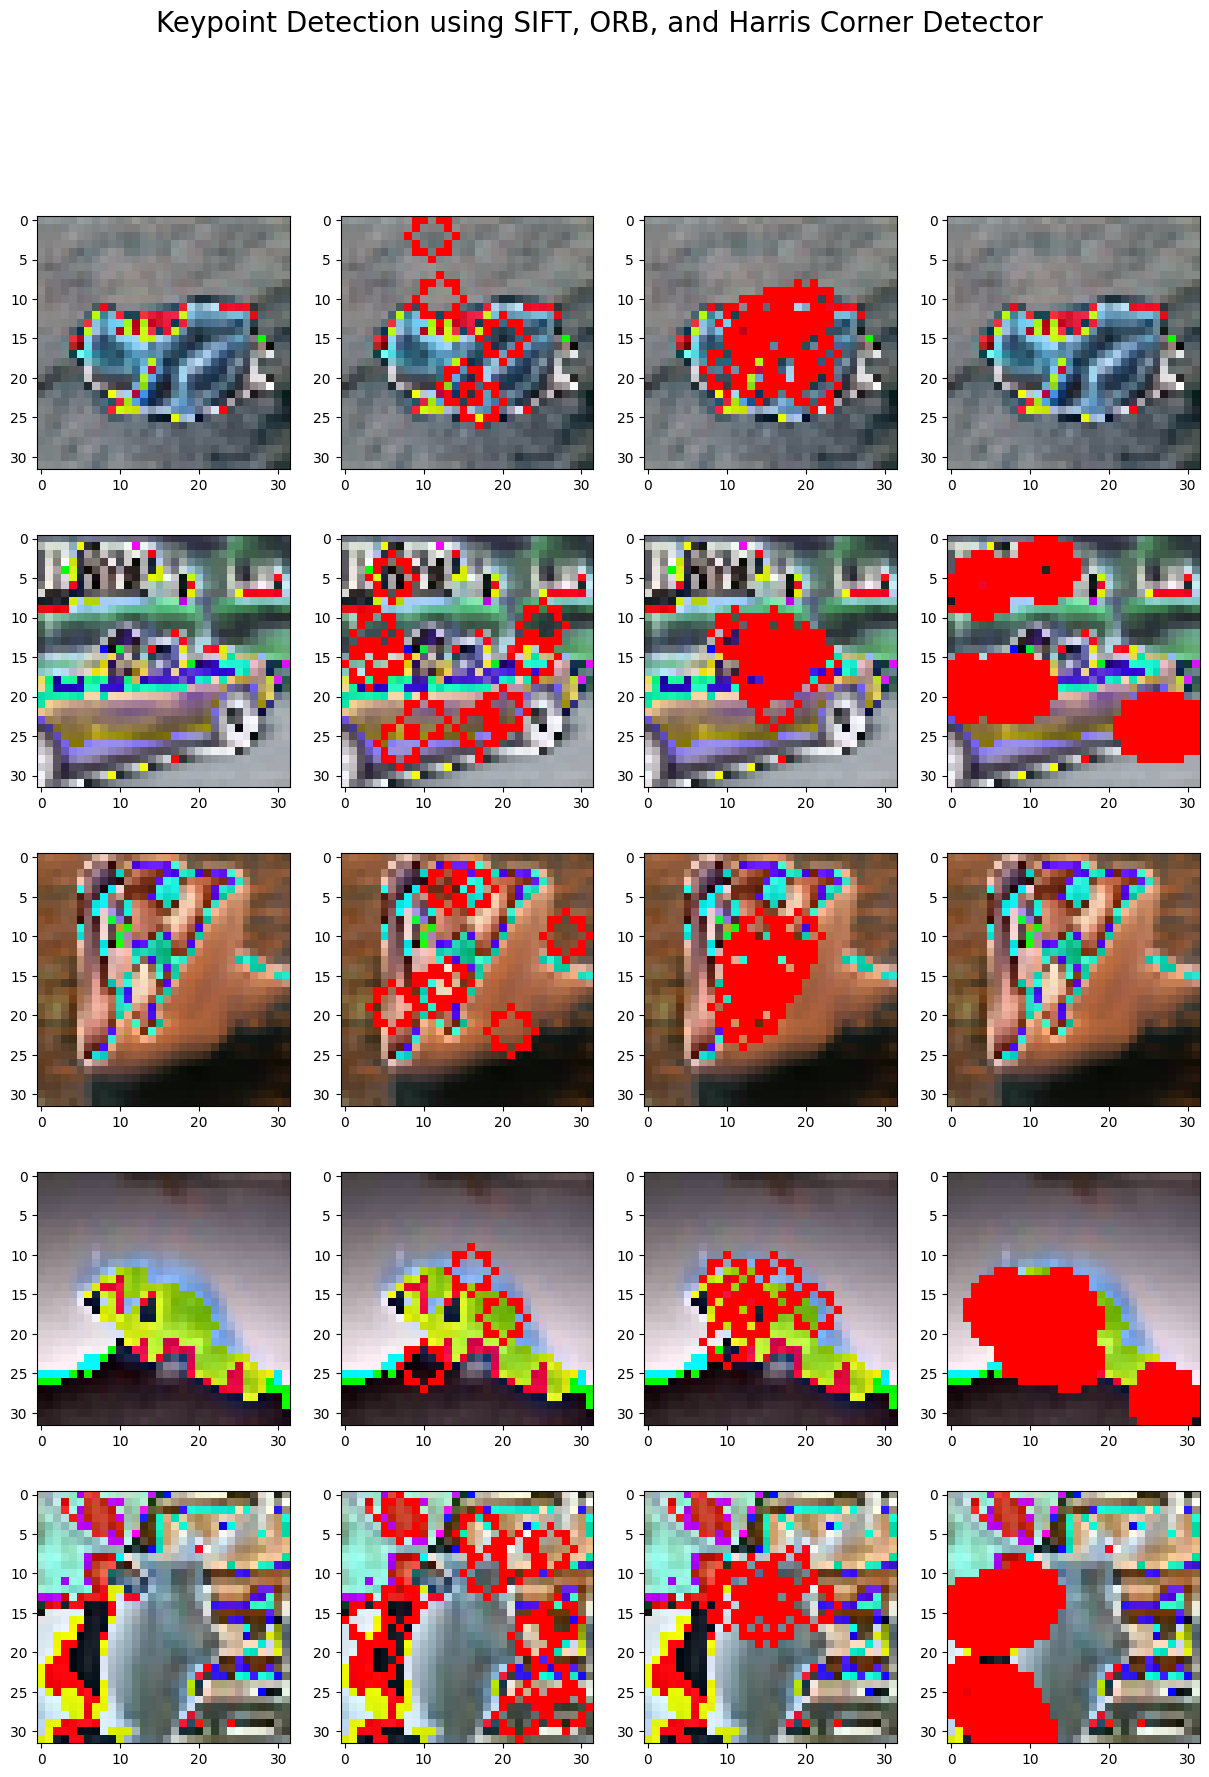

In [41]:
def detect_keypoints_sift(image):
    sift = cv2.SIFT_create(edgeThreshold=0.01)
    keypoints, _ = sift.detectAndCompute(image, None)
    return keypoints

def detect_keypoints_orb(image):
    orb = cv2.ORB_create(edgeThreshold=10)
    keypoints = orb.detect(image, None)
    return keypoints

def detect_harris_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    harris_corners = cv2.dilate(harris_corners, None)  
    threshold = 0.01 
    keypoints = np.argwhere(harris_corners > threshold) 
    return keypoints

def draw_keypoints(image, keypoints, title):
    img_with_keypoints = image.copy()
    if len(keypoints) > 0:
        for kp in keypoints:
            if isinstance(kp, cv2.KeyPoint):
                # for SIFT and ORB 
                cv2.circle(img_with_keypoints, (int(kp.pt[0]), int(kp.pt[1])), 3, (255, 0, 0), 1)
            else:
                # for harris
                cv2.circle(img_with_keypoints, (kp[1], kp[0]), 3, (255, 0, 0), 1)  
    return img_with_keypoints

# if applied multiple times the same image could be chosen twice (or more times) - adjust?
def get_random_picture(label=None):
    classes = {'Frog': 0, 'Automobile': 1, 'Bird': 2, 'Cat': 3, 'Deer': 4}
    if label is not None:
        matching_indices = [i.item() for i in torch.where(train_labels == classes[label])[0]]
        random_index = np.random.choice(matching_indices)
        return train_images[random_index].numpy(), random_index
    else:
        random_index = np.random.randint(0, train_images.shape[0])
        return train_images[random_index].numpy(), random_index

classes = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']
images = [get_random_picture(label)[0] for label in classes]

fig, axs = plt.subplots(len(classes), 4, figsize=(15, 20))
fig.suptitle('Keypoint Detection using SIFT, ORB, and Harris Corner Detector', fontsize=20)

for i, cls in enumerate(classes):
    img = images[i]
    img = (img * 255).astype(np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    sift_keypoints = detect_keypoints_sift(img)
    orb_keypoints = detect_keypoints_orb(img)
    harris_keypoints = detect_harris_corners(img)

    axs[i, 0].imshow(img)
    axs[i, 1].imshow(draw_keypoints(img, sift_keypoints, f'SIFT - {cls}'))
    axs[i, 2].imshow(draw_keypoints(img, orb_keypoints, f'ORB - {cls}'))
    axs[i, 3].imshow(draw_keypoints(img, harris_keypoints, f'Harris - {cls}'))

plt.show()


<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

WARNING clustering 20873 points to 1000 centroids: please provide at least 39000 training points


Clustering 20873 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.39 s, search 0.08 s): objective=2.09337 imbalance=5.481 nsplit=808       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.94 s, search 0.18 s): objective=1.94485 imbalance=5.481 nsplit=808        
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.35 s, search 0.26 s): objective=2.34207 imbalance=5.481 nsplit=808       
Outer iteration 3 / 5
  Iteration 19 (1.82 s, search 0.36 s): objective=2.32211 imbalance=5.481 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (2.19 s, search 0.44 s): objective=2.0005 imbalance=5.481 nsplit=808        


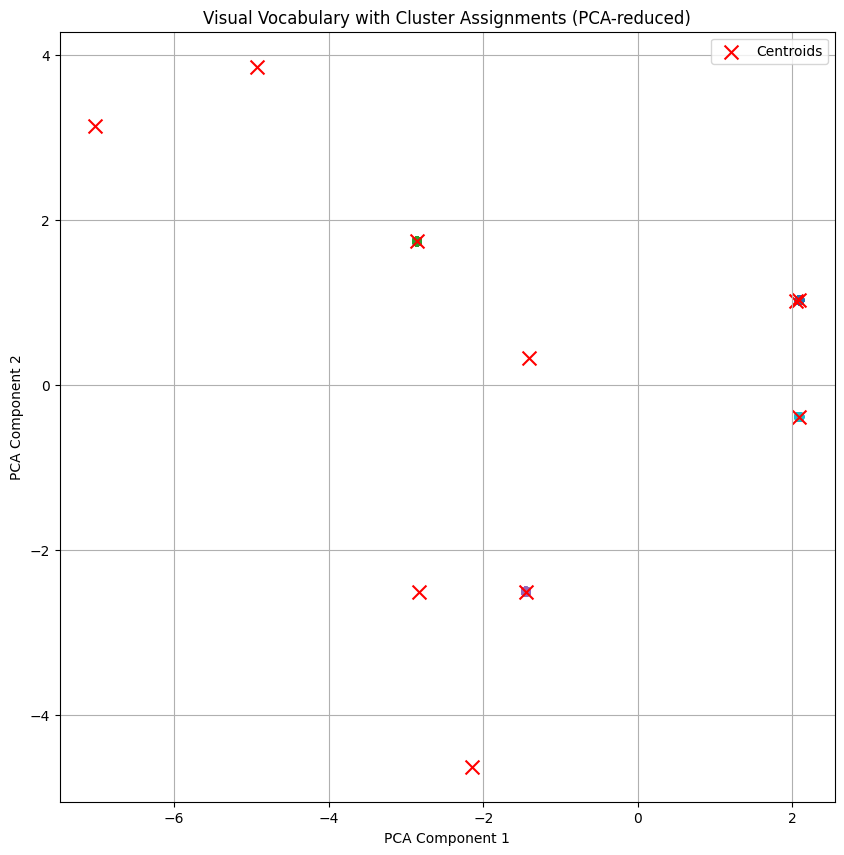

WARNING clustering 17882 points to 1000 centroids: please provide at least 39000 training points


Clustering 17882 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.11 s, search 0.10 s): objective=1803.22 imbalance=1.145 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.21 s, search 0.19 s): objective=1831.76 imbalance=1.152 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (0.34 s, search 0.31 s): objective=1807.82 imbalance=1.140 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (0.40 s, search 0.37 s): objective=1794.53 imbalance=1.135 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 19 (0.48 s, search 0.44 s): objective=1825 imbalance=1.152 nsplit=0          


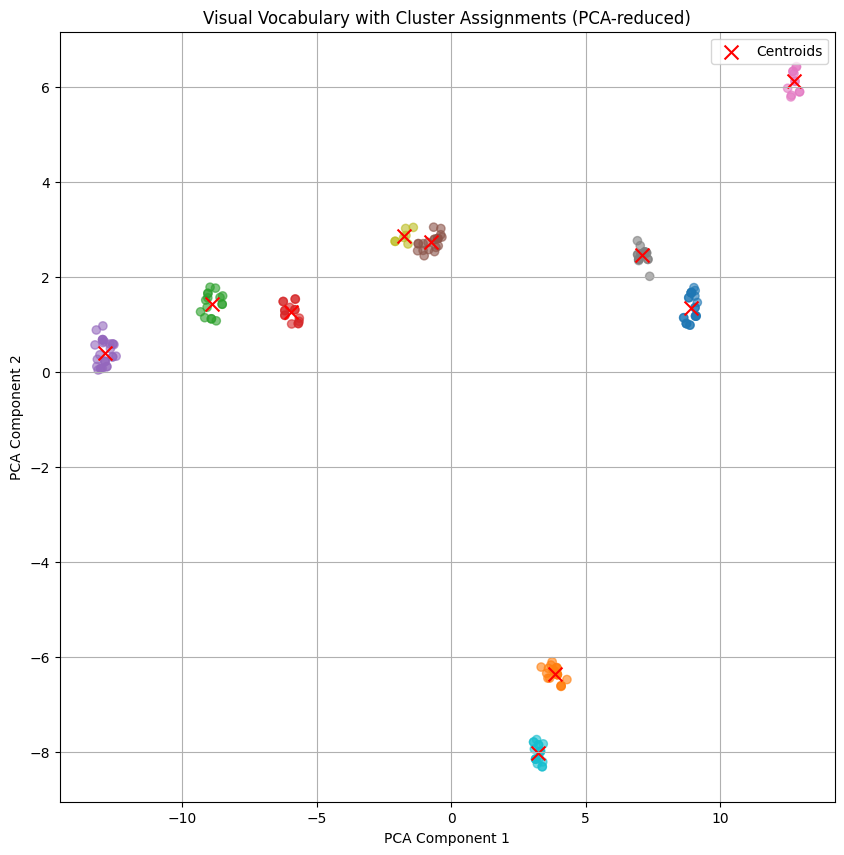

Clustering 28375 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 28375 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.49 s, search 0.12 s): objective=3.32152 imbalance=5.477 nsplit=808       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.96 s, search 0.25 s): objective=3.21962 imbalance=5.477 nsplit=808       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.36 s, search 0.35 s): objective=2.66396 imbalance=5.477 nsplit=808        
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (1.92 s, search 0.48 s): objective=3.01984 imbalance=5.477 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (2.41 s, search 0.62 s): objective=3.62924 imbalance=5.477 nsplit=808        


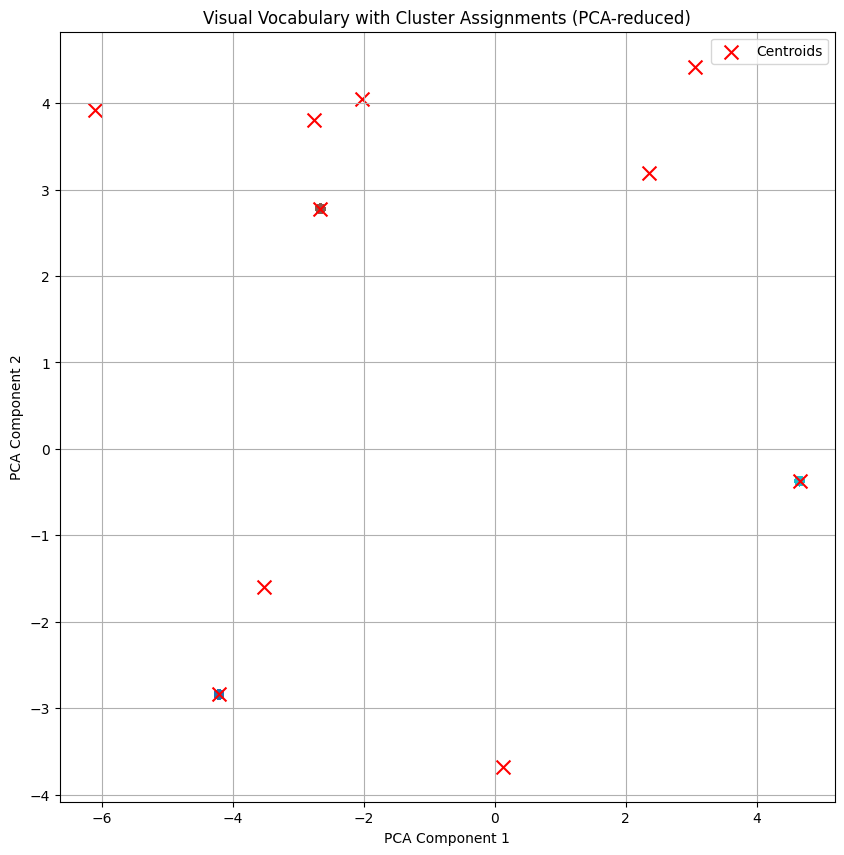

WARNING clustering 23903 points to 1000 centroids: please provide at least 39000 training points


Clustering 23903 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.08 s, search 0.08 s): objective=2487.5 imbalance=1.137 nsplit=0        
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.16 s, search 0.14 s): objective=2407.82 imbalance=1.125 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (0.24 s, search 0.22 s): objective=2464 imbalance=1.140 nsplit=0          
Outer iteration 3 / 5
  Iteration 19 (0.33 s, search 0.29 s): objective=2475.74 imbalance=1.139 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.41 s, search 0.37 s): objective=2485.18 imbalance=1.145 nsplit=0       


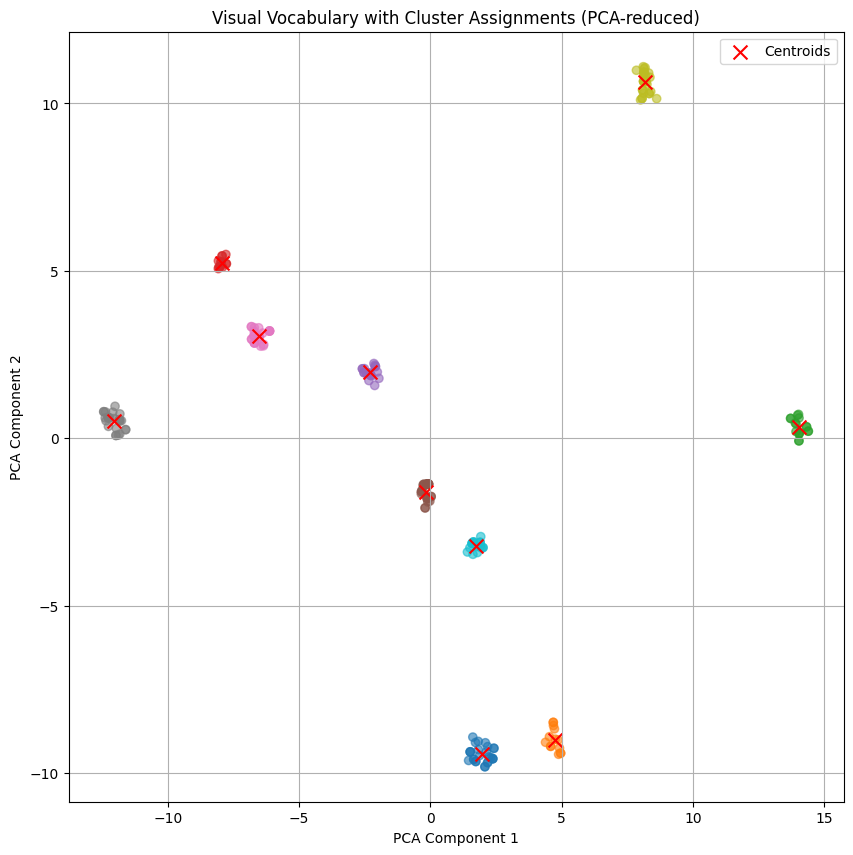

WARNING clustering 35166 points to 1000 centroids: please provide at least 39000 training points


Clustering 35166 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.53 s, search 0.17 s): objective=4.285 imbalance=5.462 nsplit=808          
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (1.03 s, search 0.31 s): objective=3.21088 imbalance=5.462 nsplit=808       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.59 s, search 0.47 s): objective=2.9843 imbalance=5.462 nsplit=808         
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (2.04 s, search 0.60 s): objective=4.18684 imbalance=5.462 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (2.58 s, search 0.76 s): objective=3.65384 imbalance=5.462 nsplit=808        


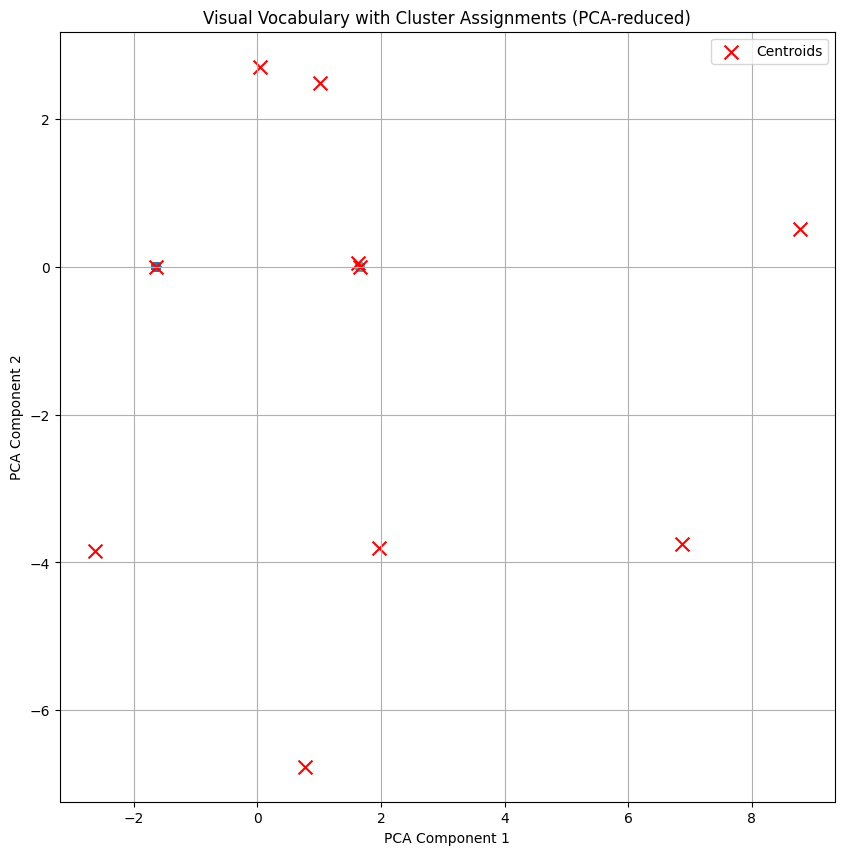

Clustering 29277 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.14 s, search 0.12 s): objective=3081.49 imbalance=1.132 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5


WARNING clustering 29277 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.24 s, search 0.21 s): objective=3047.23 imbalance=1.128 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (0.33 s, search 0.30 s): objective=3067.01 imbalance=1.128 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (0.43 s, search 0.39 s): objective=3108.18 imbalance=1.132 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.53 s, search 0.47 s): objective=3066.68 imbalance=1.125 nsplit=0       


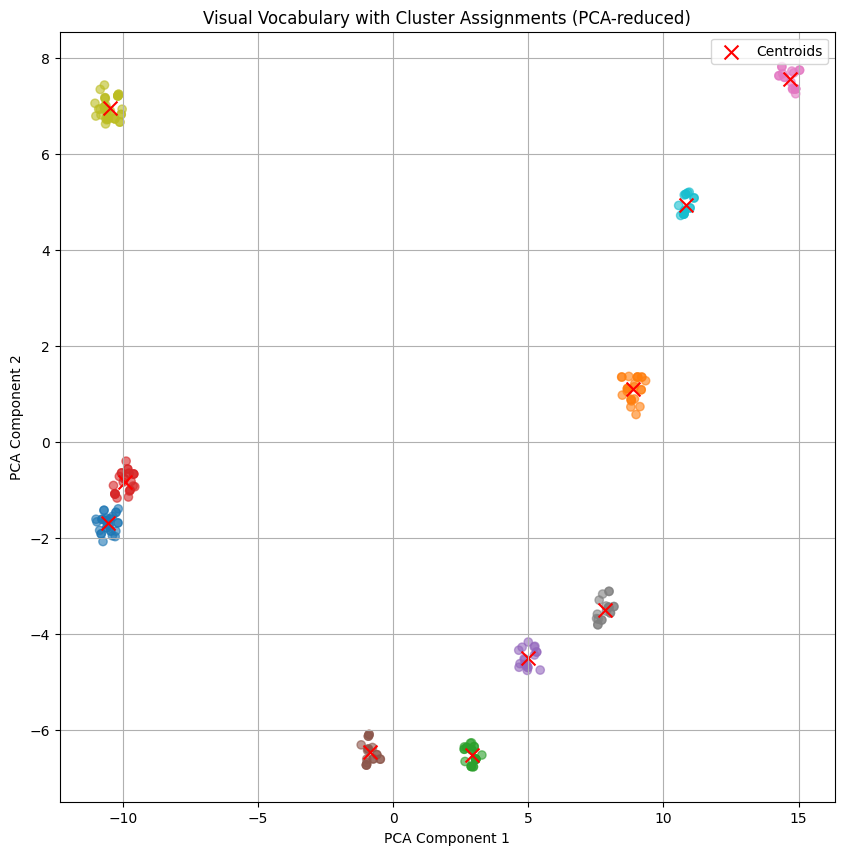

{'orb_0.3': array([[19.960957, 15.029312],
        [13.97267 , 12.023449],
        [20.938519, 13.038112],
        ...,
        [18.981428, 20.019512],
        [19.181211, 14.414065],
        [21.082155, 12.949294]], dtype=float32),
 'sift_0.3': array([[25.861042 , 15.808701 ],
        [23.260777 ,  6.9559283],
        [ 8.796681 , 10.660628 ],
        ...,
        [19.75317  , 17.165283 ],
        [22.25288  , 14.313831 ],
        [ 9.676162 , 12.122018 ]], dtype=float32),
 'orb_0.4': array([[10.989247, 13.012683],
        [ 9.99999 , 11.999989],
        [13.959011, 10.029316],
        ...,
        [17.999983, 19.199947],
        [16.062592, 19.92199 ],
        [19.037107, 19.960938]], dtype=float32),
 'sift_0.4': array([[12.031187 ,  8.84943  ],
        [14.727211 ,  8.101738 ],
        [27.079878 , 12.749572 ],
        ...,
        [ 8.881178 , 11.693037 ],
        [18.86428  , 18.535677 ],
        [ 3.8321855, 26.033983 ]], dtype=float32),
 'orb_0.5': array([[11.964878, 19.05572 ],

In [45]:
# YOUR CODE HERE
from sklearn.decomposition import PCA
import faiss

def extract_features(images, method):
    features = []
    for img in images:
        img = (img * 255).astype(np.uint8) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        if method == 'sift':
            descriptors = detect_keypoints_sift(img)
        elif method == 'orb':
            descriptors = detect_keypoints_orb(img)
        elif method == "harris":
            descriptors = detect_harris_corners(img)
        if descriptors is not None and len(descriptors) > 0:
            features.extend(descriptors)  

    features = [(k.pt[0], k.pt[1]) for k in features]
    features = np.array(features)

    return features

def kmeans(features, num_clusters=1000):
    d = features.shape[1]
    kmeans = faiss.Kmeans(d=d, k=num_clusters, niter=20, nredo=5, verbose=True)
    kmeans.train(features)

    _, assignments = kmeans.index.search(features, 1) 
    return kmeans.centroids, assignments.flatten()

def visualize_clusters(features, centroids, assignments):
    if len(features) == 0:
        print("No features to visualize.")
        return None
    pca = PCA(n_components=2)
    try:
        reduced_features = pca.fit_transform(features)
        reduced_centroids = pca.transform(centroids)  
    except Exception as e:
        print("PCA failed:", e)
        return None

    plt.figure(figsize=(10, 10))

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=assignments, cmap='tab10', alpha=0.6)
    
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], color='red', marker='x', s=100, label="Centroids")
    
    plt.title('Visual Vocabulary with Cluster Assignments (PCA-reduced)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.legend()
    plt.show()

def get_relevant_points(features, assignments, clusters_wanted):
    filtered_features = []
    filtered_assignments = []
    
    for feature, assignment in zip(features, assignments):
        if assignment in clusters_wanted:
            filtered_features.append(feature)
            filtered_assignments.append(assignment)
    
    return filtered_features, filtered_assignments

def get_centroids(train_images, percentages = [.3, .4, .5], methods = ["orb", "sift"], visualize=True, number_of_clusters_to_display=10):
    centroids_dict = {}
    for percent in percentages:
        if percent < 1:
            num_images = int(len(train_images) * percent)
            sampled_images = [get_random_picture()[0] for _ in range(num_images)]
        else:
            sampled_images = train_images
        for method in methods:
            features = extract_features(sampled_images, method)
            centroids, assignments = kmeans(features)  
            #unique, counts = np.unique(assignments, return_counts=True)
            #assignment_counts = dict(zip(unique, counts))
            #print(assignment_counts)

            if visualize:
                features_filtered, assignments_filtered = get_relevant_points(features, assignments, list(range(number_of_clusters_to_display)))
                visualize_clusters(features_filtered, centroids[:number_of_clusters_to_display], assignments_filtered)
            centroids_dict[f"{method}_{percent}"] = centroids
    return centroids_dict

get_centroids(train_images)

<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

Clustering 21086 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 21086 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.85 s, search 0.16 s): objective=2.01042 imbalance=5.510 nsplit=808       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (1.27 s, search 0.25 s): objective=2.01854 imbalance=5.510 nsplit=808       
Outer iteration 2 / 5
  Iteration 19 (1.66 s, search 0.33 s): objective=6.7128 imbalance=5.541 nsplit=809        
Outer iteration 3 / 5
  Iteration 19 (2.23 s, search 0.45 s): objective=2.17772 imbalance=5.510 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (2.67 s, search 0.53 s): objective=4.05562 imbalance=5.548 nsplit=809       
Clustering 17855 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.07 s, search 0.06 s): objective=1808.61 imbalance=1.167 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.13 s, search 0.11 s): objective=1774.71 imbalance=1.166 nsplit=0       
Objective improved: keep new clusters
Outer iterat

WARNING clustering 17855 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.25 s, search 0.23 s): objective=1808.52 imbalance=1.167 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.35 s, search 0.31 s): objective=1743.47 imbalance=1.133 nsplit=0       
Objective improved: keep new clusters


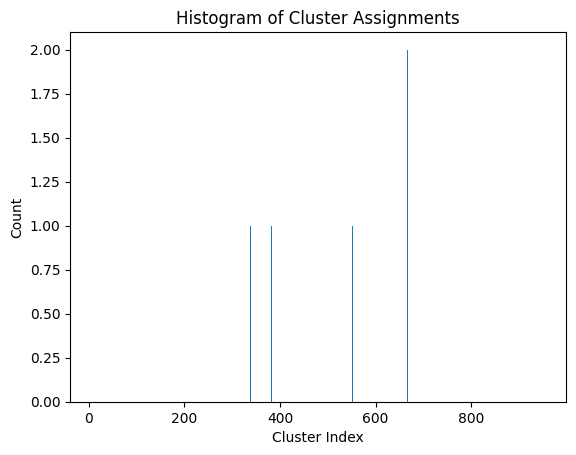

{8: 2, 195: 1, 338: 1, 382: 1, 538: 1, 552: 1, 634: 1, 667: 2, 770: 1, 951: 1}

In [47]:
# YOUR CODE HERE

def get_histogram(centroids, img, method="sift", visualize = True):
    
    d = centroids.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(centroids)
    
    features = extract_features([img], method)  
    features = np.array(features).astype('float32')  

    indices = []  

    for keypoint in features:
        k = 1  
        _, cluster_index = index.search(np.array([keypoint]), k) 
        indices.append(cluster_index[0][0]) 

    indices = np.array(indices)
    unique, counts = np.unique(indices, return_counts=True) 
    if visualize:
        plt.bar(unique, counts)
        plt.title("Histogram of Cluster Assignments")
        plt.xlabel("Cluster Index")
        plt.ylabel("Count")
        plt.show()

    histogram = dict(zip(unique, counts))
    
    return histogram
    


centroids_dict = get_centroids(train_images, visualize=False, percentages=[.3])
img = get_random_picture()[0]
get_histogram(centroids_dict[list(centroids_dict.keys())[0]], img)


<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.

Clustering 35300 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 35300 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.72 s, search 0.23 s): objective=3.9361 imbalance=5.456 nsplit=808        
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (1.32 s, search 0.42 s): objective=3.02335 imbalance=5.456 nsplit=808       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.85 s, search 0.58 s): objective=4.03188 imbalance=5.456 nsplit=808       
Outer iteration 3 / 5
  Iteration 19 (2.45 s, search 0.76 s): objective=3.65965 imbalance=5.456 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (2.89 s, search 0.88 s): objective=3.92674 imbalance=5.456 nsplit=808       


WARNING clustering 30050 points to 1000 centroids: please provide at least 39000 training points


Clustering 30050 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.17 s, search 0.15 s): objective=3122 imbalance=1.111 nsplit=0          
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.29 s, search 0.25 s): objective=3133.57 imbalance=1.115 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (0.39 s, search 0.34 s): objective=3145.16 imbalance=1.125 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (0.50 s, search 0.44 s): objective=3171.25 imbalance=1.120 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.60 s, search 0.53 s): objective=3165.77 imbalance=1.116 nsplit=0       


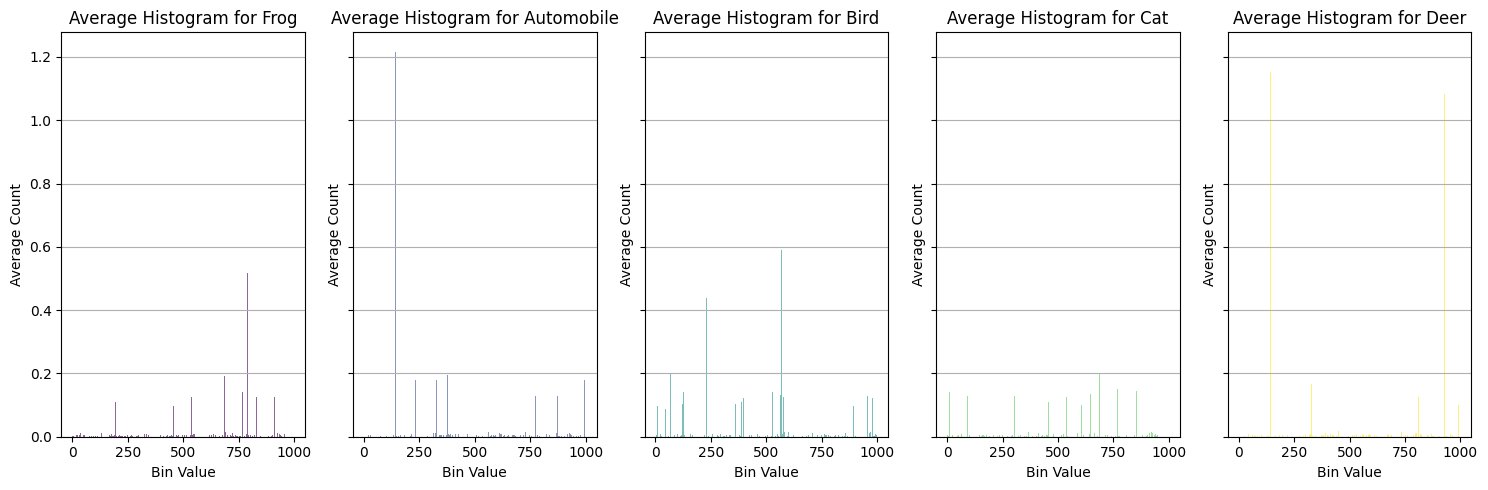

{'Frog': {71: 0.011,
  143: 1.105,
  263: 0.001,
  790: 0.516,
  912: 0.124,
  230: 0.499,
  388: 0.117,
  604: 0.001,
  503: 0.004,
  606: 0.129,
  687: 0.191,
  729: 0.01,
  768: 0.142,
  92: 0.109,
  538: 0.126,
  568: 0.614,
  928: 1.057,
  933: 0.539,
  207: 0.016,
  363: 0.12,
  457: 0.096,
  525: 0.013,
  564: 0.133,
  611: 0.007,
  903: 0.005,
  321: 0.133,
  397: 0.161,
  835: 0.009,
  233: 0.168,
  328: 0.147,
  413: 0.008,
  995: 0.109,
  122: 0.095,
  376: 0.001,
  384: 0.008,
  647: 0.114,
  845: 0.007,
  945: 0.008,
  11: 0.102,
  134: 0.002,
  831: 0.125,
  852: 0.001,
  9: 0.076,
  23: 0.009,
  126: 0.114,
  377: 0.166,
  786: 0.008,
  991: 0.096,
  45: 0.099,
  168: 0.007,
  344: 0.004,
  956: 0.142,
  21: 0.016,
  68: 0.175,
  136: 0.006,
  464: 0.103,
  479: 0.007,
  837: 0.007,
  103: 0.009,
  165: 0.008,
  249: 0.004,
  304: 0.16,
  474: 0.007,
  706: 0.004,
  361: 0.152,
  577: 0.129,
  335: 0.009,
  528: 0.141,
  535: 0.001,
  331: 0.002,
  771: 0.007,
  774: 0.1

In [48]:
from collections import defaultdict


def get_mean_histogram(centroids, train_images, train_labels, visualize = True):
    classes = {'Frog': 0, 'Automobile': 1, 'Bird': 2, 'Cat': 3, 'Deer': 4}
    
    histogram_sums = {class_name: defaultdict(int) for class_name in classes}
    class_counts = {class_name: 0 for class_name in classes}

    for class_name, class_index in classes.items():
        matching_indices = [i.item() for i in torch.where(train_labels == class_index)[0]]
        
        for index in matching_indices:
            img = train_images[index].numpy()
            
            histogram = get_histogram(centroids, img, visualize=False)
            
            for bin_value, count in histogram.items():
                histogram_sums[class_name][bin_value] += count
            
            class_counts[class_name] += 1

    average_histograms = {}
    for class_name in classes:
        total_images = class_counts[class_name]
        if total_images > 0:
            avg_histogram = {bin_value: count / total_images for bin_value, count in histogram_sums[class_name].items()}
            average_histograms[class_name] = avg_histogram
        else:
            average_histograms[class_name] = {}

    if visualize:
        num_classes = len(average_histograms)
        bin_labels = list(average_histograms.values())[0].keys() 

        fig, axes = plt.subplots(1, num_classes, figsize=(15, 5), sharey=True)

        colors = plt.cm.viridis(np.linspace(0, 1, num_classes))  

        for i, (class_name, avg_histogram) in enumerate(average_histograms.items()):
            counts = [avg_histogram.get(bin_value, 0) for bin_value in bin_labels]
            
            axes[i].bar(bin_labels, counts, alpha=0.6, color=colors[i])
            
            axes[i].set_title(f'Average Histogram for {class_name}')
            axes[i].set_xlabel('Bin Value')
            axes[i].set_ylabel('Average Count')
            axes[i].grid(axis='y')

        plt.tight_layout()
        plt.show()



    return average_histograms

centroids_dict = get_centroids(train_images, visualize=False, percentages=[.5])
get_mean_histogram(centroids_dict[list(centroids_dict.keys())[0]], train_images, train_labels)


<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [40]:
# YOUR CODE HERE

import numpy as np
import torch
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# converts histogram of format {12:value, 15:value, ..} to e.g. {0:value, 1:0, 2:0, 3:4,  .., 999:0} for each cluster
def histogram_to_feature_vector(histogram, max_bins=1000):
    feature_vector = np.zeros(max_bins)  
    for bin_value, count in histogram.items():
        if bin_value < max_bins:
            feature_vector[bin_value] = count 
    return feature_vector

def extract_features_from_histograms(histograms):
    features = []
    for histogram in histograms:
        feature_vector = histogram_to_feature_vector(histogram)
        features.append(feature_vector)
    return np.array(features) 

def create_feature_vectors(images, centroids):
    histograms = []
    for image in images:
        img_histogram = get_histogram(centroids_dict[list(centroids_dict.keys())[0]], image, visualize=False)
        histograms.append(img_histogram)
    feature_array = extract_features_from_histograms(histograms)
    return feature_array

train_images_section_7, unused_images, train_labels_section_7, unused_labels = train_test_split(
    train_images, train_labels, test_size=0.5, random_state=42
)

train_images_section_7 = np.array([image.numpy() for image in train_images_section_7])
unused_images = np.array([image.numpy() for image in unused_images])
centroids_dict = get_centroids(train_images_section_7, 1, visualize=False)
centroids = centroids_dict[list(centroids_dict.keys())[0]]


# Step 2: Extract features using the two techniques
features_1 = create_feature_vectors(train_images_section_7, centroids)
features_2 = create_feature_vectors(train_images_section_7, centroids)

# Step 3: Create One-vs-Rest SVM classifiers for both feature sets
ovr_svm_1 = OneVsRestClassifier(svm.SVC(kernel='linear'))  # Using linear kernel for simplicity
ovr_svm_2 = OneVsRestClassifier(svm.SVC(kernel='linear'))

# Step 4: Train the classifiers
ovr_svm_1.fit(features_1, train_labels_section_7)
ovr_svm_2.fit(features_2, train_labels_section_7)

# Step 5: Evaluate classifiers (optional, for demonstration purposes)
# You may want to test on another validation set
# Here we are just showing how to evaluate the classifiers on the unused data
unused_features_1 = create_feature_vectors(unused_images, centroids)
unused_features_2 = create_feature_vectors(unused_images, centroids)

predictions_1 = ovr_svm_1.predict(unused_features_1)
predictions_2 = ovr_svm_2.predict(unused_features_2)

print("Classification Report for Features 1:\n", classification_report(unused_labels, predictions_1))
print("Classification Report for Features 2:\n", classification_report(unused_labels, predictions_2))



        


WARNING clustering 10594 points to 1000 centroids: please provide at least 39000 training points


Clustering 10594 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.35 s, search 0.04 s): objective=1.52914 imbalance=5.525 nsplit=808        
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.68 s, search 0.08 s): objective=0.924774 imbalance=5.525 nsplit=808       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.01 s, search 0.11 s): objective=1.16557 imbalance=5.525 nsplit=808        
Outer iteration 3 / 5
  Iteration 19 (1.34 s, search 0.15 s): objective=1.11523 imbalance=5.525 nsplit=808        
Outer iteration 4 / 5
  Iteration 19 (1.66 s, search 0.18 s): objective=1.18106 imbalance=5.525 nsplit=808       


WARNING clustering 8498 points to 1000 centroids: please provide at least 39000 training points


Clustering 8498 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.04 s, search 0.03 s): objective=768.553 imbalance=1.226 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.07 s, search 0.06 s): objective=755.698 imbalance=1.220 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (0.10 s, search 0.08 s): objective=762.753 imbalance=1.216 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (0.13 s, search 0.11 s): objective=764.703 imbalance=1.223 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.16 s, search 0.14 s): objective=780.332 imbalance=1.241 nsplit=0       


WARNING clustering 14040 points to 1000 centroids: please provide at least 39000 training points


Clustering 14040 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.33 s, search 0.05 s): objective=1.61517 imbalance=5.499 nsplit=808       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.68 s, search 0.10 s): objective=1.18034 imbalance=5.499 nsplit=808        
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.02 s, search 0.14 s): objective=1.63837 imbalance=5.499 nsplit=808       
Outer iteration 3 / 5
  Iteration 19 (1.38 s, search 0.19 s): objective=1.56044 imbalance=5.499 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (1.80 s, search 0.26 s): objective=1.57324 imbalance=5.499 nsplit=808        
Clustering 11272 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.04 s, search 0.04 s): objective=1105.15 imbalance=1.210 nsplit=0       
Objective improved: keep new cluster

WARNING clustering 11272 points to 1000 centroids: please provide at least 39000 training points


Clustering 17904 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 17904 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.35 s, search 0.06 s): objective=2.11392 imbalance=5.477 nsplit=808       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.68 s, search 0.12 s): objective=1.87721 imbalance=5.477 nsplit=808       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 19 (1.05 s, search 0.19 s): objective=1.41325 imbalance=5.477 nsplit=808       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 19 (1.44 s, search 0.27 s): objective=1.76508 imbalance=5.477 nsplit=808       
Outer iteration 4 / 5
  Iteration 19 (1.77 s, search 0.33 s): objective=1.49413 imbalance=5.477 nsplit=808       
Clustering 14106 points in 2D to 1000 clusters, redo 5 times, 20 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.05 s, search 0.04 s): objective=1411.35 imbalance=1.179 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.09 s, search 0.08 s): objective=1372.48 imbala

WARNING clustering 14106 points to 1000 centroids: please provide at least 39000 training points


  Iteration 19 (0.24 s, search 0.21 s): objective=1413.66 imbalance=1.182 nsplit=0       
Classification Report for Features 1:
               precision    recall  f1-score   support

           0       0.21      0.21      0.21       499
           1       0.18      0.19      0.18       500
           2       0.19      0.22      0.20       502
           3       0.22      0.21      0.21       502
           4       0.17      0.14      0.16       497

    accuracy                           0.19      2500
   macro avg       0.19      0.19      0.19      2500
weighted avg       0.19      0.19      0.19      2500

Classification Report for Features 2:
               precision    recall  f1-score   support

           0       0.21      0.21      0.21       499
           1       0.18      0.19      0.18       500
           2       0.19      0.22      0.20       502
           3       0.22      0.21      0.21       502
           4       0.17      0.14      0.16       497

    accuracy     

In [39]:
print(unused_labels)
print(predictions_1)
print(features_1[1])
#predictions_1 = ovr_svm_1.predict(unused_features_1)
#predictions_2 = ovr_svm_2.predict(unused_features_2)

#print("Classification Report for Features 1:\n", classification_report(unused_labels, predictions_1))
#print("Classification Report for Features 2:\n", classification_report(unused_labels, predictions_2))


tensor([2, 2, 0,  ..., 0, 3, 1])
[1 3 4 ... 3 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

In [ ]:
# YOUR CODE HERE

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

In [ ]:
# YOUR CODE HERE

<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [ ]:
# YOUR CODE HERE

Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text. 

In [ ]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [ ]:
# YOUR CODE HERE

In [ ]:
# Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
stacked_image_features = torch.cat(image_features_list)
stacked_target_labels = torch.cat(target_labels_list)

To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [ ]:
# YOUR CODE HERE

To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [ ]:
# YOUR CODE HERE

To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [ ]:
# YOUR CODE HERE

<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |

### - End of Notebook -